In [1]:
import pandas
import seaborn
from matplotlib import pyplot

In [2]:
MajorCityCSV = 'GlobalLandTemperaturesByMajorCity.csv'

In [3]:
MajorCityDF = pandas.read_csv(
    MajorCityCSV,
    engine='pyarrow',
    dtype_backend='pyarrow'
)

MajorCityDF = MajorCityDF.sort_values(['City', 'dt'])

In [4]:
# se crea esta columna para obtener un valor promedio por año de las temperaturas
MajorCityDF['year'] = MajorCityDF.dt.dt.year

# Y esta otra lo mismo pero por mes
MajorCityDF['month'] = MajorCityDF.dt.dt.month

In [5]:
MajorCityDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239177 entries, 0 to 239176
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype               
---  ------                         --------------   -----               
 0   dt                             239177 non-null  date32[day][pyarrow]
 1   AverageTemperature             228175 non-null  double[pyarrow]     
 2   AverageTemperatureUncertainty  228175 non-null  double[pyarrow]     
 3   City                           239177 non-null  string[pyarrow]     
 4   Country                        239177 non-null  string[pyarrow]     
 5   Latitude                       239177 non-null  string[pyarrow]     
 6   Longitude                      239177 non-null  string[pyarrow]     
 7   year                           239177 non-null  int64[pyarrow]      
 8   month                          239177 non-null  int64[pyarrow]      
dtypes: date32[day][pyarrow](1), double[pyarrow](2), int64[pyarrow](2), string[py

In [6]:
MajorCityDF.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,1
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,2
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,3


In [7]:
MajorCityDF.describe()

,dt,AverageTemperature,AverageTemperatureUncertainty,year,month
count,239177,228175.0,228175.0,239177.0,239177.0
mean,1910-11-09,18.125969,0.969343,1910.3948,6.496156
min,1743-11-01,-26.772,0.04,1743.0,1.0
25%,1864-02-01,12.71,0.34,1864.0,3.0
50%,1914-02-01,20.428,0.592,1914.0,6.0
75%,1963-12-01,25.918,1.32,1963.0,9.0
max,2013-09-01,38.283,14.037,2013.0,12.0
std,NaN,10.0248,0.979644,63.230923,3.450576


In [8]:
# Analizamos la cantidad de datos por cada pais
print(MajorCityDF.value_counts('Country').head(3))
print(MajorCityDF.value_counts('Country').tail(3))
print(f'total: {MajorCityDF.value_counts('Country').shape[0]}')

Country
India     36582
China     35444
Brazil    12930
Name: count, dtype: int64
Country
Angola    1893
Sudan     1857
Peru      1591
Name: count, dtype: int64
total: 49


In [9]:
# Analizamos la cantidad de datos por cada ciudad
print(MajorCityDF.value_counts('City').head(3))
print(MajorCityDF.value_counts('City').tail(3))
print(f'total: {MajorCityDF.value_counts('City').shape[0]}')

City
Chicago    3239
Berlin     3239
Kiev       3239
Name: count, dtype: int64
City
Cape Town     1881
Umm Durman    1857
Lima          1591
Name: count, dtype: int64
total: 100


In [10]:
cols = ['AverageTemperature', 'AverageTemperatureUncertainty']

MajorCityDF[cols] = (
    MajorCityDF
    .groupby('City')[cols]
    .apply(lambda s: s.interpolate(method='linear', limit_direction='both'))
    .reset_index(level=0, drop=True)
)


<Axes: xlabel='month', ylabel='AverageTemperature'>

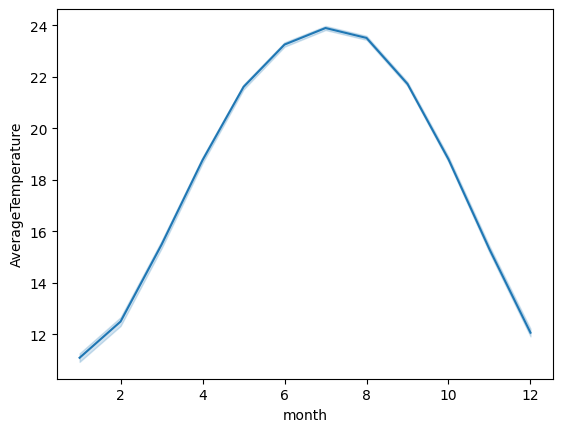

In [11]:
seaborn.lineplot(
    data = MajorCityDF,
    x='month',
    y='AverageTemperature',
)

<Axes: xlabel='year', ylabel='mean_country_t'>

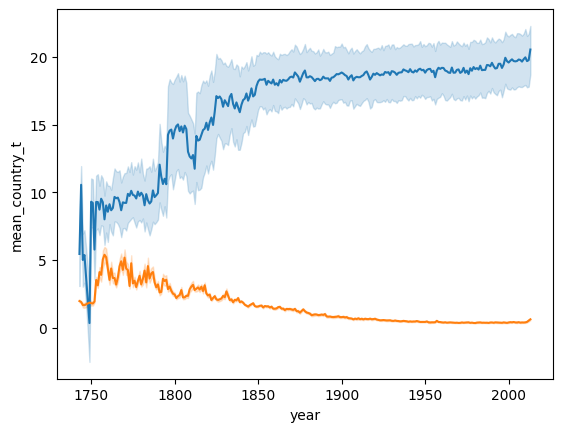

In [12]:
df = (
    MajorCityDF.groupby(['Country', 'year'])
    .agg(
        mean_country_t=('AverageTemperature', 'mean'),
        mean_uncertainty_country = ('AverageTemperatureUncertainty', 'mean')
    )
    .reset_index()
)

seaborn.lineplot(
    data=df,  
    x="year", 
    y="mean_country_t", 
)
seaborn.lineplot(
    data=df,  
    x="year", 
    y="mean_uncertainty_country", 
)

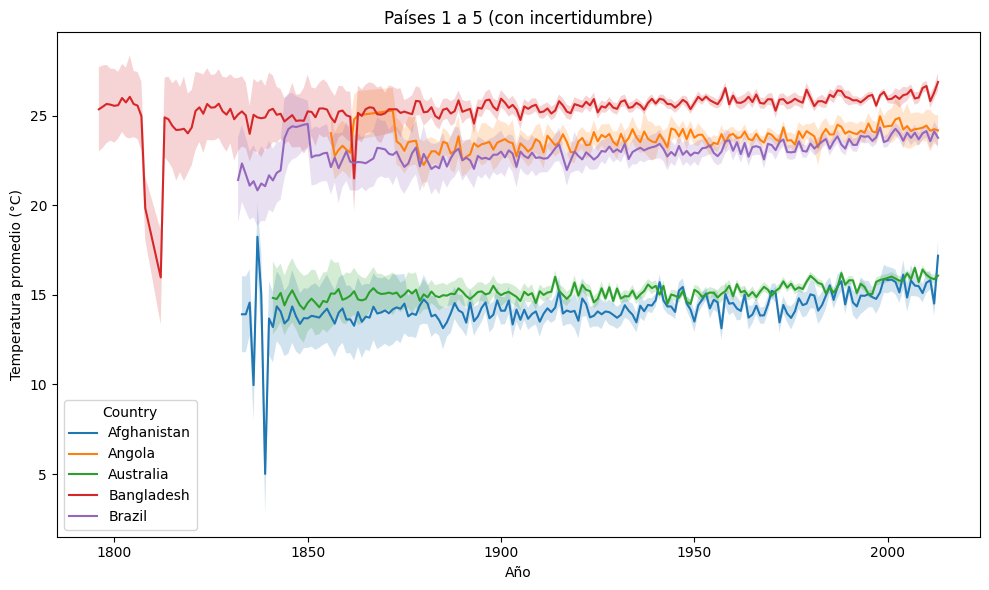

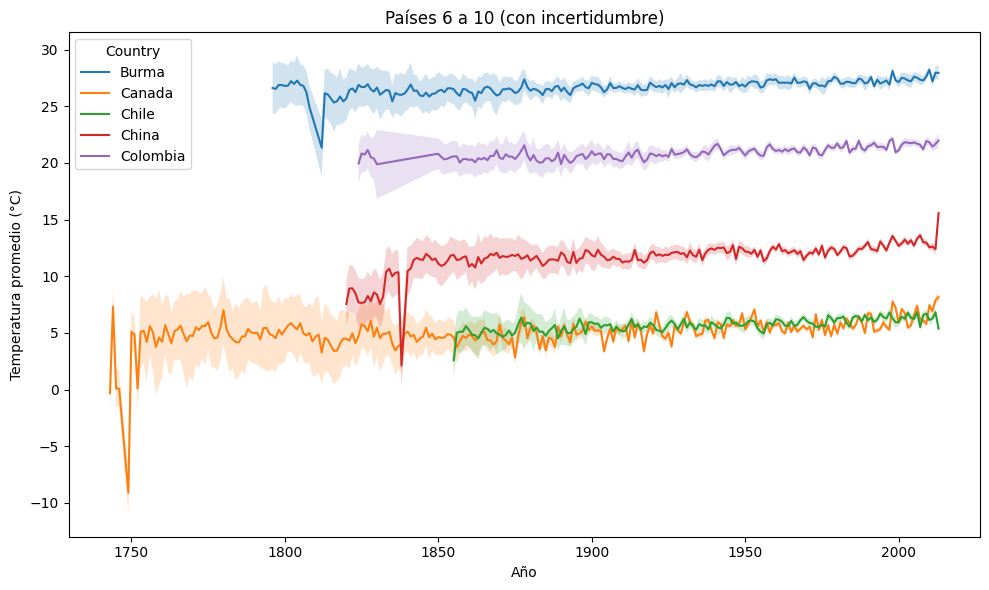

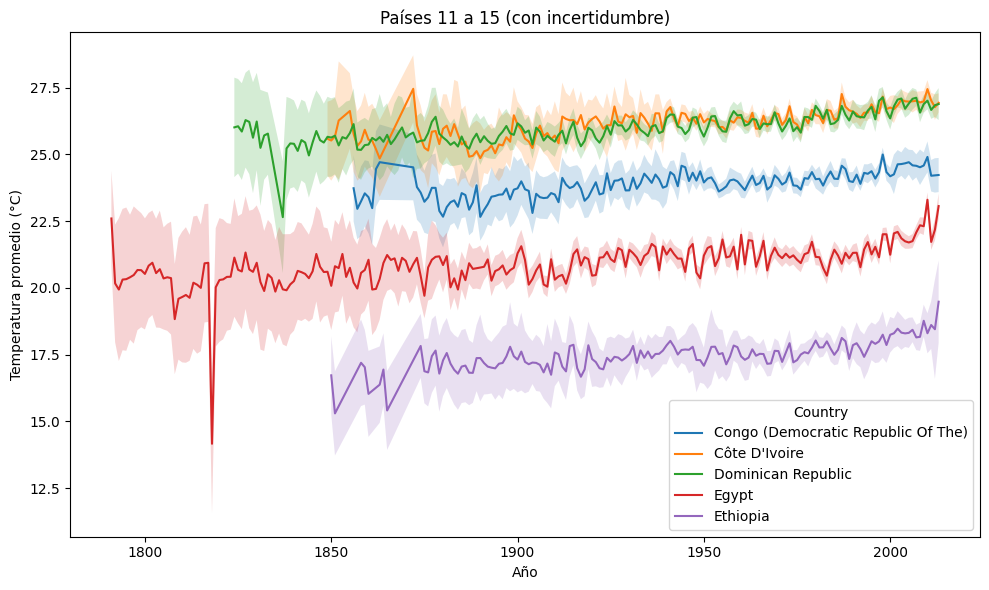

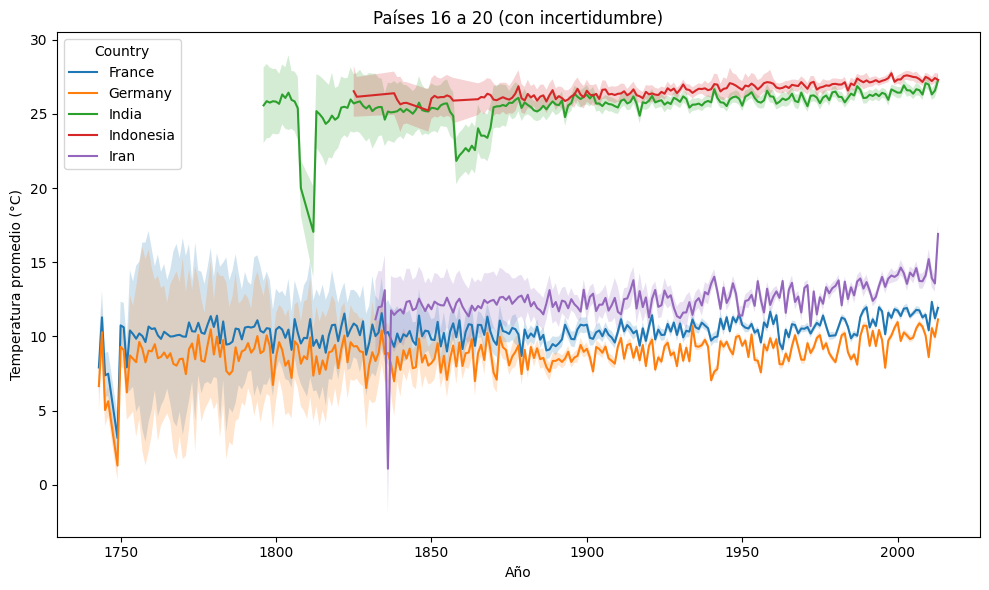

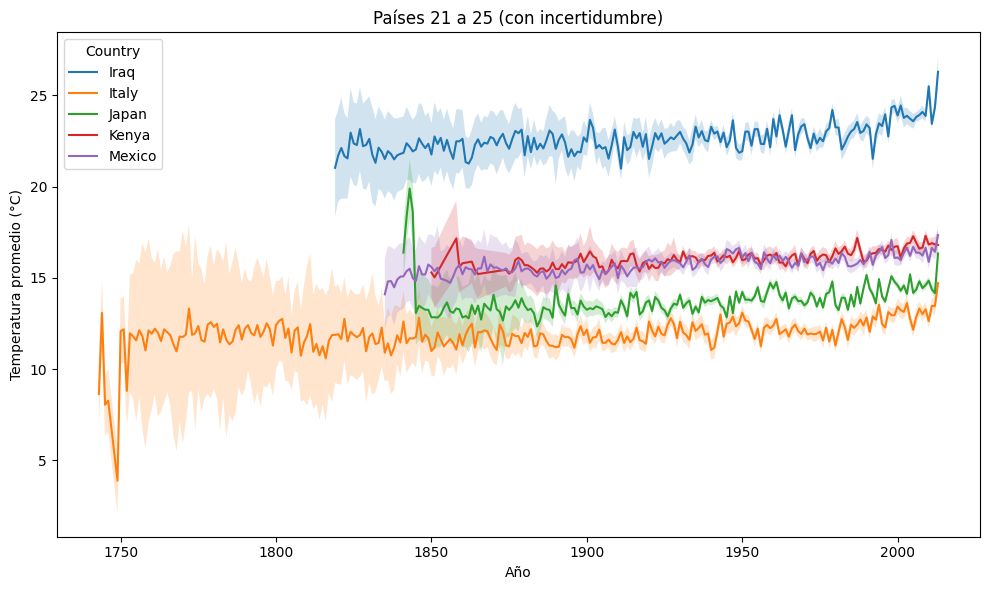

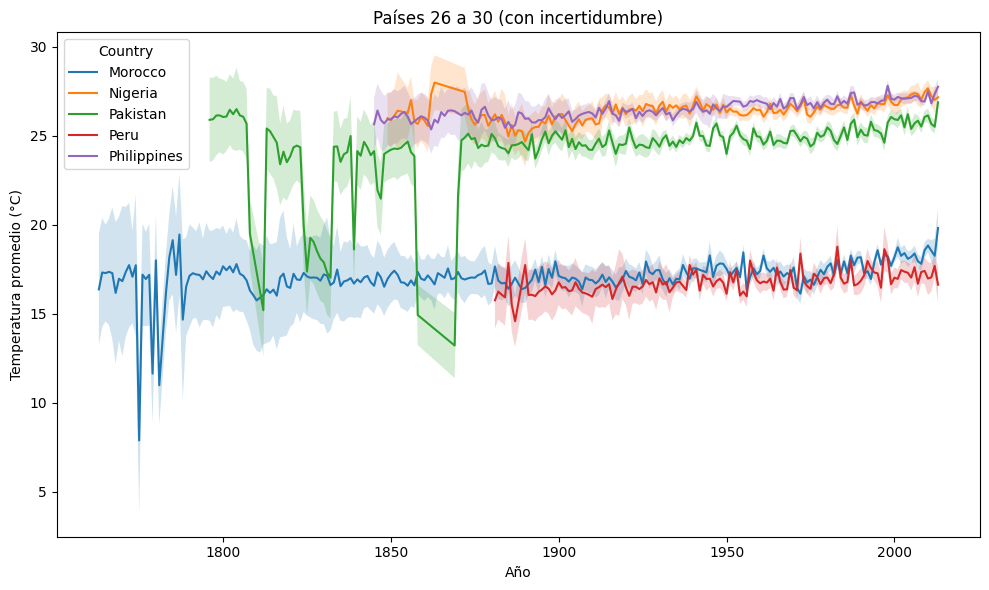

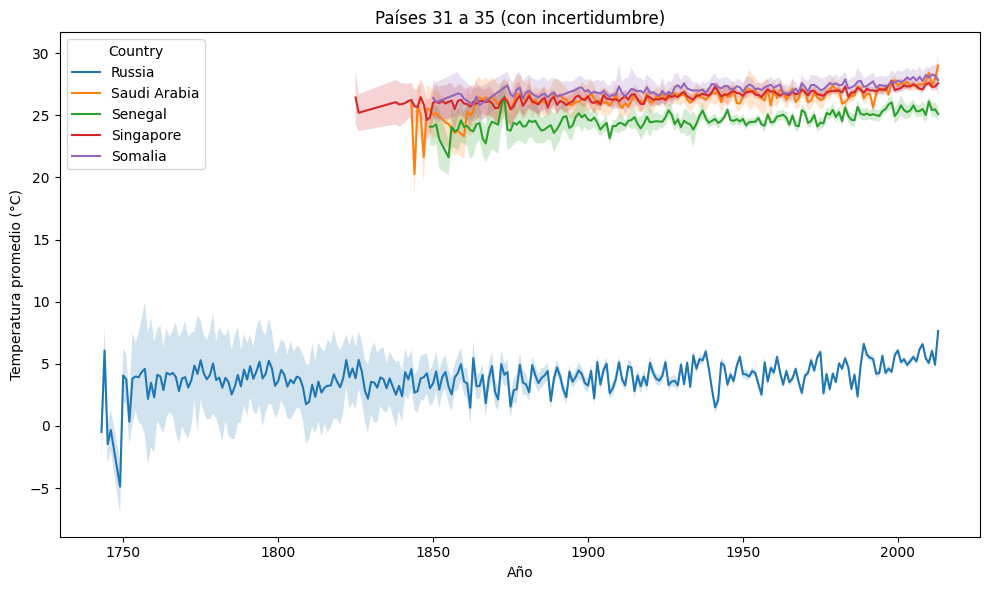

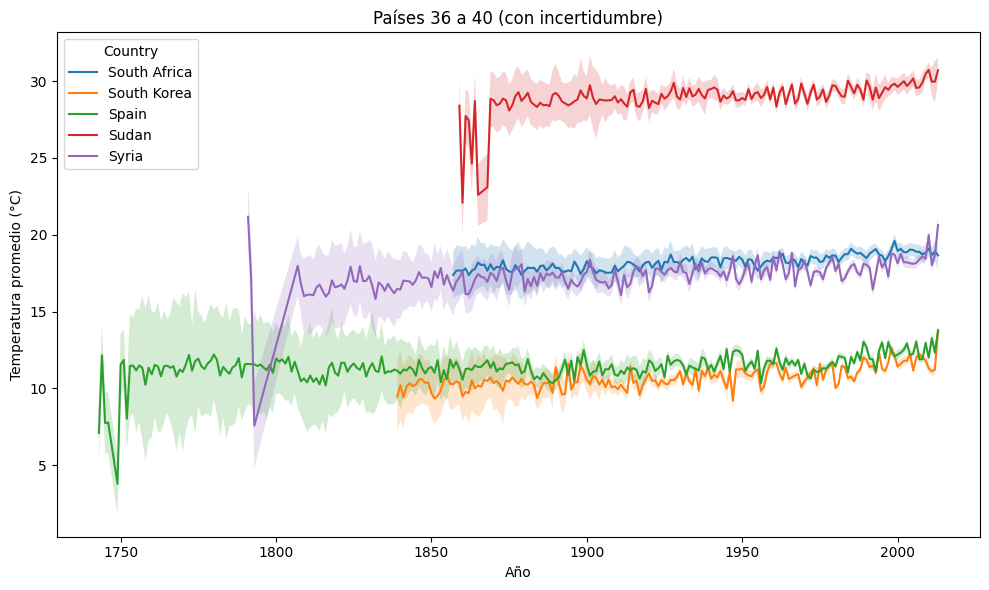

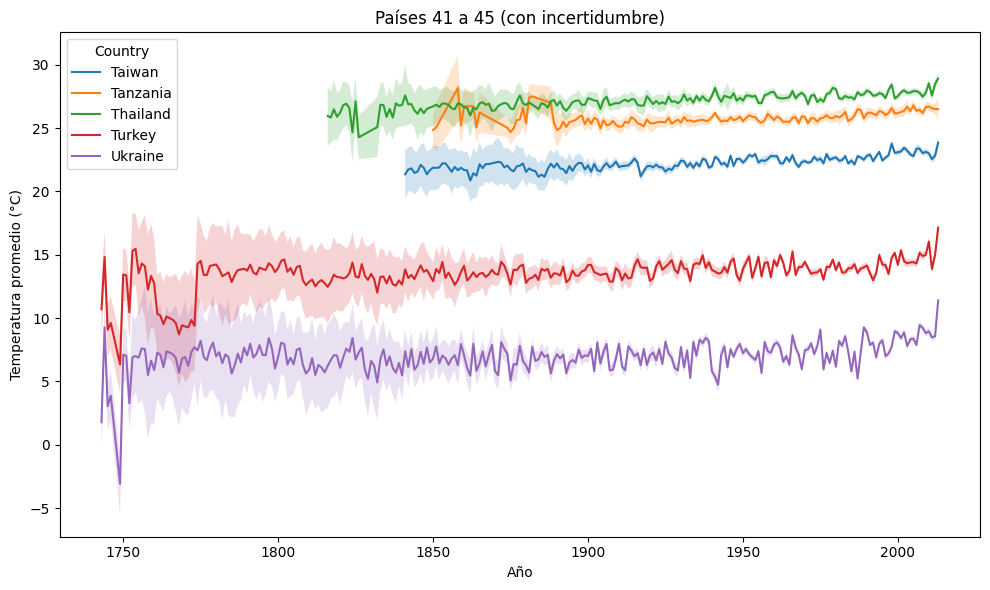

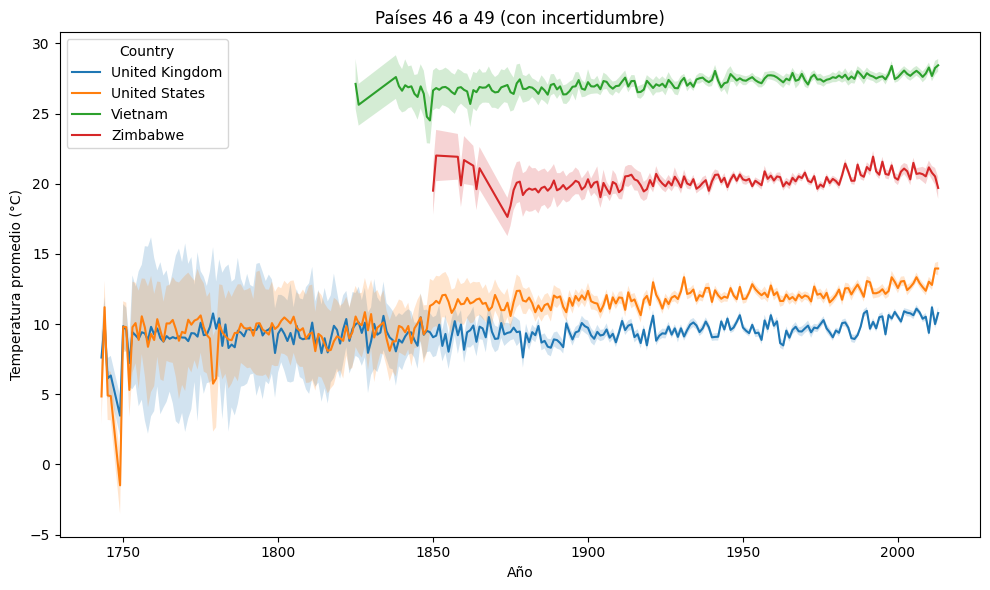

In [14]:
df = (
    MajorCityDF.groupby(['Country', 'year'])
    .agg(
        mean_country_t=('AverageTemperature', 'mean'),
        mean_uncertainty_country=('AverageTemperatureUncertainty', 'mean')
    )
    .reset_index()
)

df["y_min"] = df["mean_country_t"] - df["mean_uncertainty_country"]
df["y_max"] = df["mean_country_t"] + df["mean_uncertainty_country"]

paises = df["Country"].unique()
batch_size = 5

for i in range(0, len(paises), batch_size):
    subset_paises = paises[i:i+batch_size]
    df_batch = df[df["Country"].isin(subset_paises)]

    pyplot.figure(figsize=(10, 6))

    # Línea principal
    seaborn.lineplot(
        data=df_batch,
        x="year",
        y="mean_country_t",
        hue="Country",
        legend="full"
    )

    # Banda de incertidumbre
    for p in subset_paises:
        temp = df_batch[df_batch["Country"] == p]
        pyplot.fill_between(
            temp["year"],
            temp["y_min"],
            temp["y_max"],
            alpha=0.2
        )

    pyplot.title(f"Países {i+1} a {i+len(subset_paises)} (con incertidumbre)")
    pyplot.xlabel("Año")
    pyplot.ylabel("Temperatura promedio (°C)")
    pyplot.tight_layout()
    pyplot.show()
